#Part 1

In [ ]:
!gdown -q 1hsyA7pTTNGtVrUMxZ_Y74-slLj0hF0UX

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [ ]:
data = pd.read_csv('/content/fraud_detection_dataset.csv')

In [ ]:
data

,duration_hour,type,amount,name_original,balance_original_before,balance_original_after,name_destination,balance_destination_before,balance_destination_after,is_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


<ipython-input-5-0ef79e61e76e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


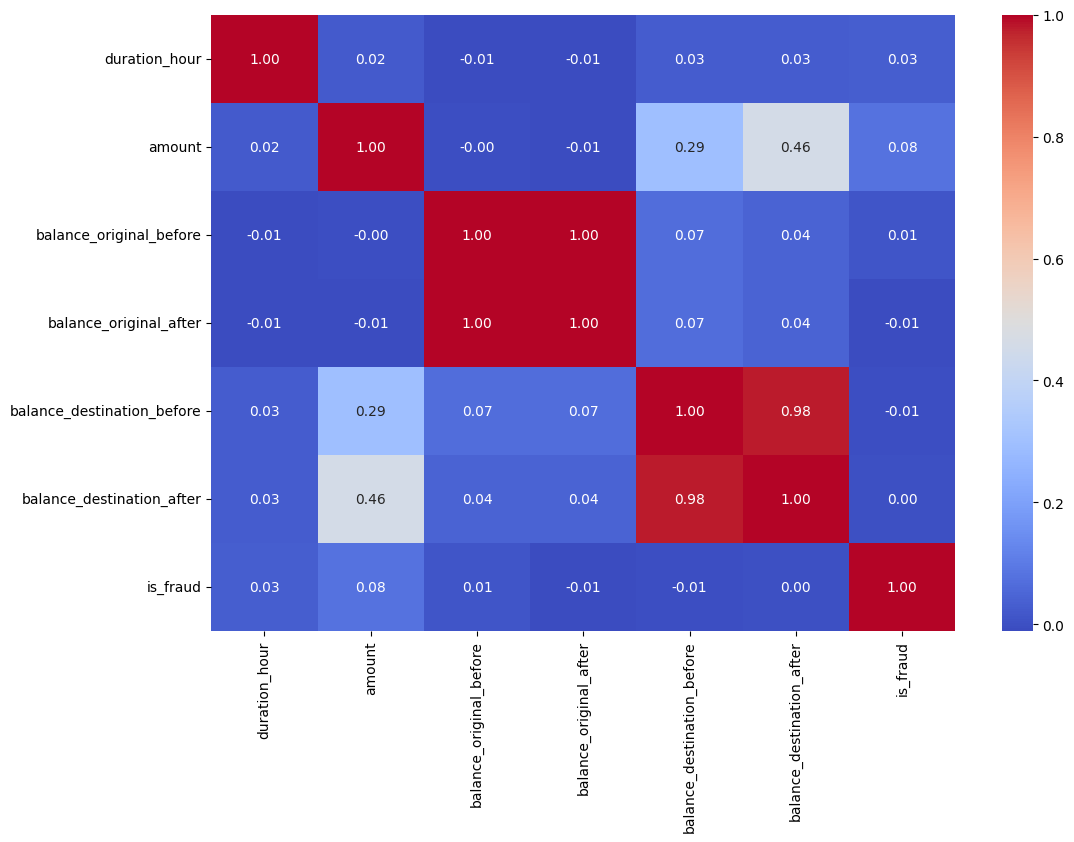

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
# Dropping highly correlated features
data.drop(['balance_original_after', 'balance_destination_after', 'name_original', 'name_destination'], axis=1, inplace=True)

In [ ]:
data.head()

,duration_hour,type,amount,balance_original_before,balance_destination_before,is_fraud
0,1,PAYMENT,9839.64,170136.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.0,1
3,1,CASH_OUT,181.00,181.0,21182.0,1
4,1,PAYMENT,11668.14,41554.0,0.0,0


In [ ]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=42, stratify=data['is_fraud'])

transformer = make_column_transformer(
    (OneHotEncoder(), ['type']),
    remainder='passthrough'
)

X_train = df_train.drop(['is_fraud'], axis=1)
y_train = df_train['is_fraud']

X_test = df_test.drop(['is_fraud'], axis=1)
y_test = df_test['is_fraud']

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('sample dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 4765805, 1: 6160})
sample dataset shape Counter({0: 61600, 1: 6160})


In [ ]:
# Logistic Regression with default parameters
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Confusion Matrix:
 [[1580927    7675]
 [    919    1134]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.13      0.55      0.21      2053

    accuracy                           0.99   1590655
   macro avg       0.56      0.77      0.60   1590655
weighted avg       1.00      0.99      1.00   1590655



In [ ]:
lr_params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}
lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5)
lr_grid.fit(X_train, y_train)
y_pred_lr = lr_grid.best_estimator_.predict(X_test)
best_params_lr = lr_grid.best_params_
print("Best Parameters for Logistic Regression:", best_params_lr)
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best Parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Logistic Regression Confusion Matrix:
 [[1572666   15936]
 [    741    1312]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1588602
           1       0.08      0.64      0.14      2053

    accuracy                           0.99   1590655
   macro avg       0.54      0.81      0.57   1590655
weighted avg       1.00      0.99      0.99   1590655



In [ ]:
# KNN with default parameters
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluation
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


KNN Confusion Matrix:
 [[1574865   13737]
 [    348    1705]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.11      0.83      0.19      2053

    accuracy                           0.99   1590655
   macro avg       0.56      0.91      0.60   1590655
weighted avg       1.00      0.99      0.99   1590655



In [ ]:
knn_params = {'n_neighbors': [5, 10], 'algorithm': ['auto', 'ball_tree']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3)
knn_grid.fit(X_train, y_train)
y_pred_knn = knn_grid.best_estimator_.predict(X_test)
best_params_knn = knn_grid.best_params_
print("Best Parameters for KNN:", best_params_knn)
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))

Best Parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 5}
KNN Confusion Matrix:
 [[1575836   12766]
 [    381    1672]]

KNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.12      0.81      0.20      2053

    accuracy                           0.99   1590655
   macro avg       0.56      0.90      0.60   1590655
weighted avg       1.00      0.99      0.99   1590655



In [ ]:
# Random Forest with default parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Confusion Matrix:
 [[1583204    5398]
 [    136    1917]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.26      0.93      0.41      2053

    accuracy                           1.00   1590655
   macro avg       0.63      0.97      0.70   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
rf_params = {'criterion': ['gini', 'entropy'], 'n_estimators': [50, 100], 'max_depth': [None, 10, 15]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.best_estimator_.predict(X_test)
best_params_rf = rf_grid.best_params_
print("Best Parameters for Random Forest:", best_params_rf)
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Best Parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}
Random Forest Confusion Matrix:
 [[1583090    5512]
 [    137    1916]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.26      0.93      0.40      2053

    accuracy                           1.00   1590655
   macro avg       0.63      0.96      0.70   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Use predict_proba
th = rf_grid.best_estimator_.predict_proba(X_test)[:, 1] > .9
th = th.astype(int)
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, th))
print("\nClassification Report:\n", classification_report(y_test, th))

Random Forest Confusion Matrix:
 [[1588202     400]
 [    486    1567]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.80      0.76      0.78      2053

    accuracy                           1.00   1590655
   macro avg       0.90      0.88      0.89   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Gradient Boosting with default parameters
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Evaluation
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Confusion Matrix:
 [[1582105    6497]
 [    216    1837]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.22      0.89      0.35      2053

    accuracy                           1.00   1590655
   macro avg       0.61      0.95      0.68   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
gb_params = {'loss': ['log_loss', 'exponential'], 'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2]}
gb_grid = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=3)
gb_grid.fit(X_train, y_train)
y_pred_gb = gb_grid.best_estimator_.predict(X_test)
best_params_gb = gb_grid.best_params_
print("Best Parameters for Gradient Boosting:", best_params_gb)
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'loss': 'log_loss', 'n_estimators': 200}
Gradient Boosting Confusion Matrix:
 [[1583015    5587]
 [    135    1918]]

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.26      0.93      0.40      2053

    accuracy                           1.00   1590655
   macro avg       0.63      0.97      0.70   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# Use predict_proba
th = gb_grid.best_estimator_.predict_proba(X_test)[:, 1] > .9
th = th.astype(int)
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, th))
print("\nClassification Report:\n", classification_report(y_test, th))

KNN Confusion Matrix:
 [[1587737     865]
 [    426    1627]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.65      0.79      0.72      2053

    accuracy                           1.00   1590655
   macro avg       0.83      0.90      0.86   1590655
weighted avg       1.00      1.00      1.00   1590655



In [ ]:
# AdaBoost with default parameters
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
y_pred_ab = ab.predict(X_test)

# Evaluation
print("AdaBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ab))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ab))


AdaBoost Confusion Matrix:
 [[1564575   24027]
 [    471    1582]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1588602
           1       0.06      0.77      0.11      2053

    accuracy                           0.98   1590655
   macro avg       0.53      0.88      0.55   1590655
weighted avg       1.00      0.98      0.99   1590655



In [ ]:
ab_params = {'n_estimators': [50, 100], 'learning_rate': [0.1, 1]}
ab_grid = GridSearchCV(AdaBoostClassifier(), ab_params, cv=5)
ab_grid.fit(X_train, y_train)
y_pred_ab = ab_grid.best_estimator_.predict(X_test)
best_params_ab = ab_grid.best_params_
print("Best Parameters for AdaBoost:", best_params_ab)
print("AdaBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ab))
print("\nAdaBoost Classification Report:\n", classification_report(y_test, y_pred_ab))

Best Parameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}
AdaBoost Confusion Matrix:
 [[1568297   20305]
 [    462    1591]]

AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99   1588602
           1       0.07      0.77      0.13      2053

    accuracy                           0.99   1590655
   macro avg       0.54      0.88      0.56   1590655
weighted avg       1.00      0.99      0.99   1590655



In [ ]:
# SVM with default parameters
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluation
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM Confusion Matrix:
 [[1575093   13509]
 [    574    1479]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.10      0.72      0.17      2053

    accuracy                           0.99   1590655
   macro avg       0.55      0.86      0.58   1590655
weighted avg       1.00      0.99      0.99   1590655



In [ ]:

# Convert actual and predicted values to numpy arrays for easier manipulation
y_test_array = np.array(y_test)
y_pred_gb_array = np.array(y_pred_gb)

# Identifying the indices of false negatives (actual class is 1 but predicted as 0)
false_negatives_indices = np.where((y_test_array == 1) & (y_pred_gb_array == 0))[0]

# If there are fewer than 10 false negatives, take them all; otherwise, take a sample of 10
n_samples = 10
sample_false_negatives_indices = np.random.choice(false_negatives_indices, n_samples, replace=False)

# Extracting the sample false negative rows from the original data for analysis
false_negatives_samples = df_test.iloc[sample_false_negatives_indices]

# Displaying the sampled false negatives
print(false_negatives_samples)


         duration_hour      type     amount  balance_original_before  \
286186              15  CASH_OUT  164500.81                164500.81   
1506839            144  CASH_OUT  102750.55                102750.55   
5934991            404  CASH_OUT   40359.75                 40359.75   
2976141            231  CASH_OUT  317787.12                317787.12   
5496479            380  CASH_OUT    2784.51                  2784.51   
2537764            205  CASH_OUT  128572.96                128572.96   
4863914            348  CASH_OUT  291264.20                291264.20   
800386              40  CASH_OUT   20314.97                 20314.97   
3193226            248  CASH_OUT   18035.14                 18035.14   
756498              38  CASH_OUT    2395.29                  2395.29   

         balance_destination_before  is_fraud  
286186                    685636.21         1  
1506839                   473786.58         1  
5934991                    37684.35         1  
2976141        

#Part 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [ ]:
! pip install gdown
! gdown --no-check-certificate --folder https://drive.google.com/drive/folders/15MYXbXYPd8BVyMc1txa1CNvZjftl_yQu?usp=sharing

Retrieving folder list
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing file 1ESAkl9In-r-qVOC9lJv3M2eV7cCzt8Q4 jena_climate_2009_2016.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-08-bc-docs.googleuserconten

In [ ]:
jena_climate_data = pd.read_csv('/content/data/jena_climate_2009_2016.csv')

In [ ]:
jena_climate_data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


<ipython-input-32-82139d942de5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = jena_climate_data.corr()


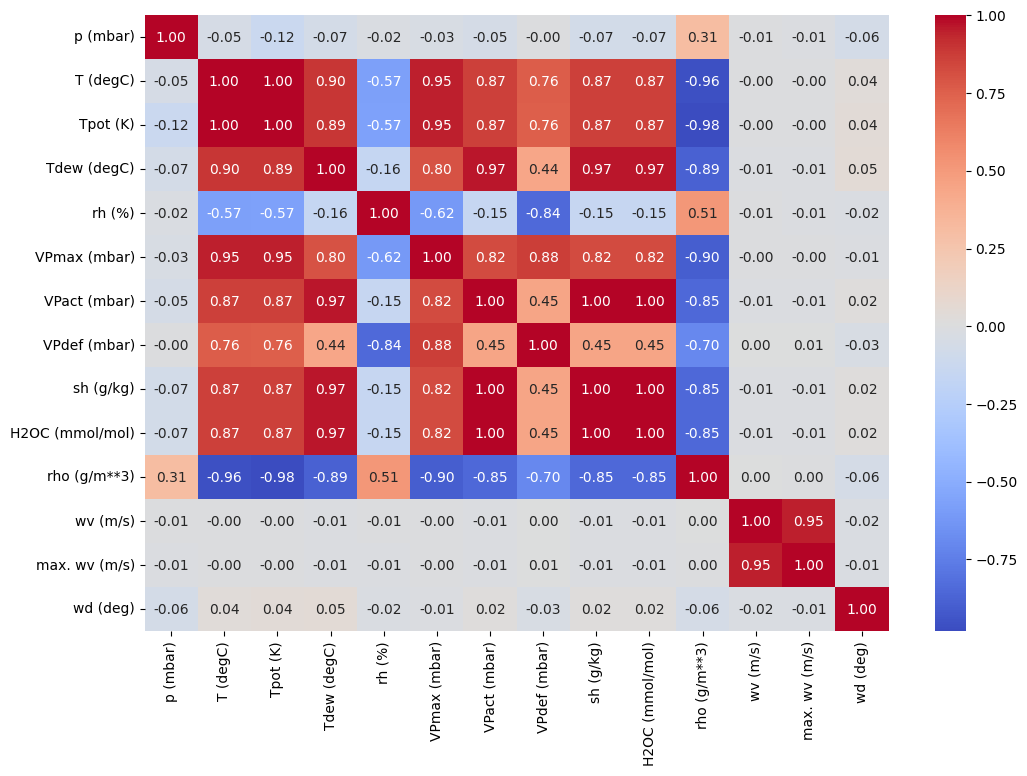

In [ ]:
corr_matrix = jena_climate_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
selected_features = ['T (degC)', 'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)']

In [ ]:
# Convert 'Date Time' to datetime
jena_climate_data['Date Time'] = pd.to_datetime(jena_climate_data['Date Time'], format='%d.%m.%Y %H:%M:%S')
features = jena_climate_data.set_index('Date Time')[selected_features]

In [ ]:
# Resample data to hourly intervals and forward-fill any missing values
hourly_data = features.resample('H').mean().ffill()

In [ ]:
# Normalize the features
scaler = StandardScaler()
hourly_data_scaled = scaler.fit_transform(hourly_data)

In [ ]:
# Function to create time series data
def create_time_series(data, past_window=6, future_window=36):
    X, y = [], []
    interval = past_window + future_window
    for i in range(len(data) - interval):
        X.append(data[i:(i + past_window)])
        y.append(data[i + past_window:i + interval, 0])  # The temperature is the first column in the selected features
    return np.array(X), np.array(y)

In [ ]:
# Creating time series data using only the selected features
X, y = create_time_series(hourly_data_scaled)

In [ ]:
# Splitting the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.375, random_state=42)  # 0.375 * 0.40 = 0.15

In [ ]:
# Define MLP model
def create_mlp_model(input_shape, output_size=36):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        Dense(output_size)
    ])
    return model

In [ ]:
# Model setup
input_shape = X_train.shape[1:]  # (36, number of selected features)
output_size = 36  # Next 6 hours at 10-minute intervals
mlp_model = create_mlp_model(input_shape, output_size)

In [ ]:
# Compile the model MSE
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Compile the model MAE
# mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

In [ ]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
1315/1315 [==============================] - 4s 2ms/step - loss: 0.2154 - val_loss: 0.1905
Epoch 2/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1865 - val_loss: 0.1823
Epoch 3/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1829 - val_loss: 0.1856
Epoch 4/10
1315/1315 [==============================] - 4s 3ms/step - loss: 0.1814 - val_loss: 0.1813
Epoch 5/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1797 - val_loss: 0.1830
Epoch 6/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1781 - val_loss: 0.1770
Epoch 7/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.1766 - val_loss: 0.1758
Epoch 8/10
1315/1315 [==============================] - 4s 3ms/step - loss: 0.1752 - val_loss: 0.1751
Epoch 9/10
1315/1315 [==============================] - 4s 3ms/step - loss: 0.1743 - val_loss: 0.1755
Epoch 10/10
1315/1315 [==============================] - 3s 2ms/step - loss: 0.172

In [ ]:
# Evaluate the model
test_loss = mlp_model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

548/548 [==============================] - 1s 2ms/step - loss: 0.1726
Test loss: 0.17257553339004517


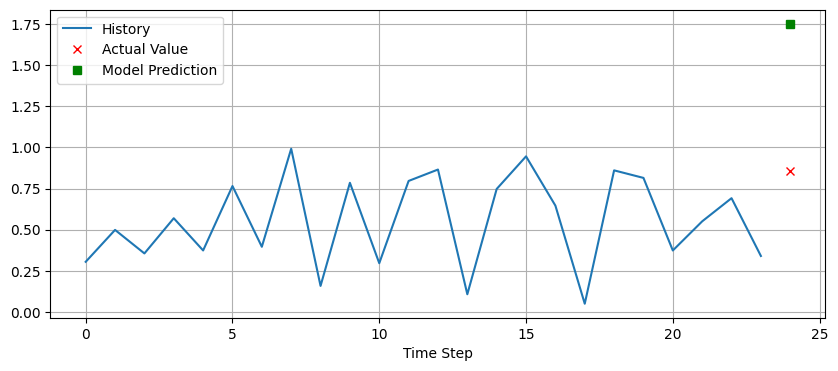

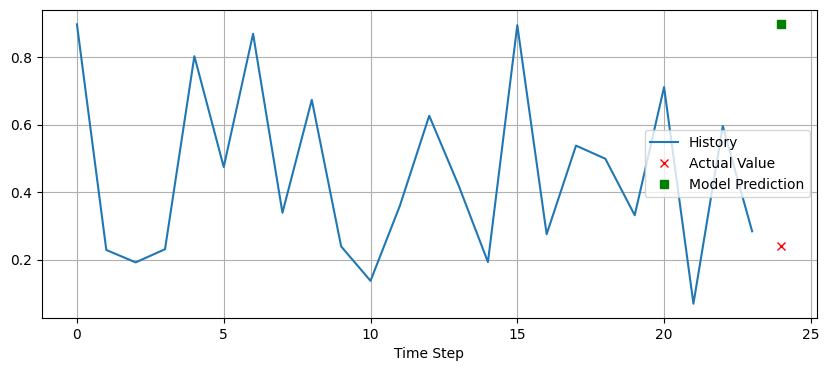

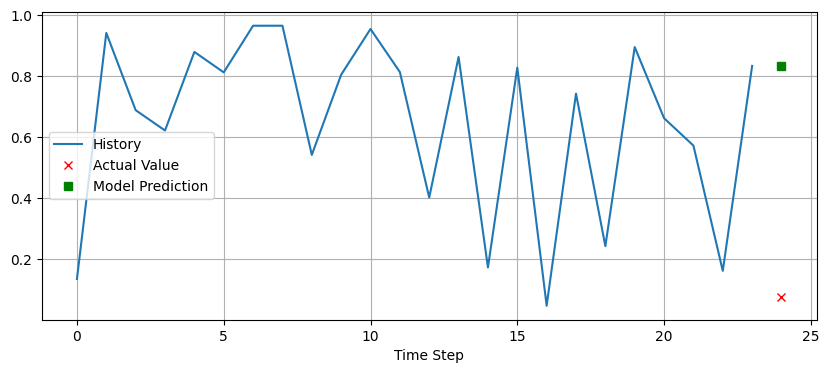

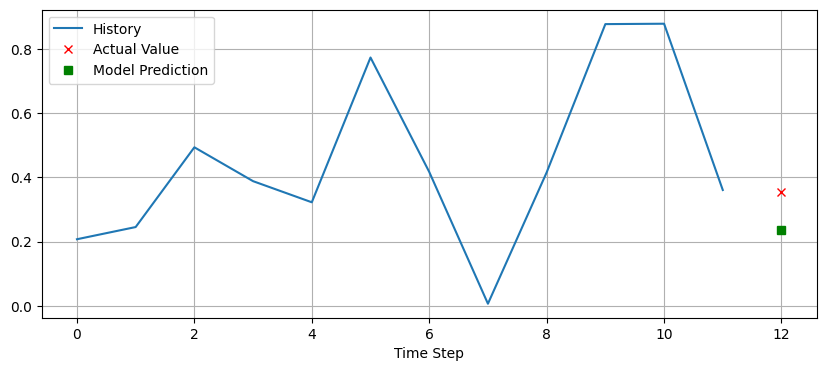

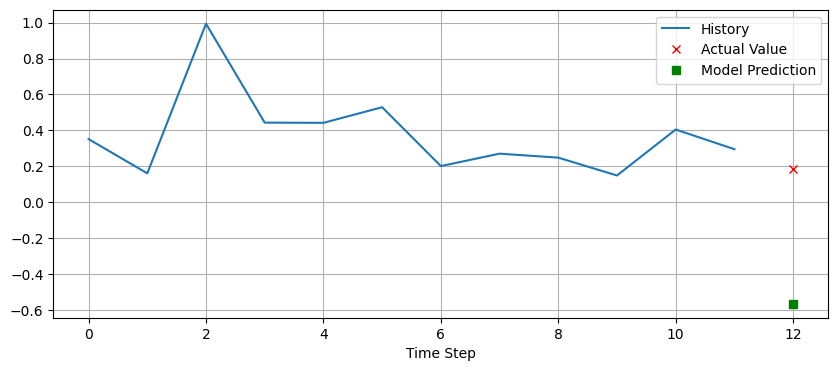

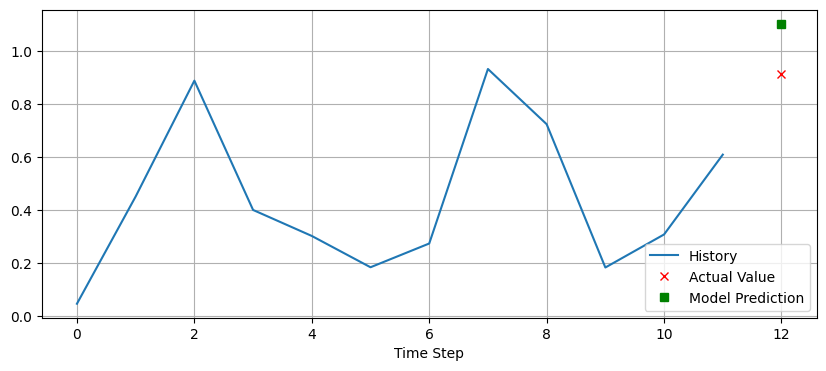

In [ ]:
original_features_count = 6
number_of_samples = 420551
timesteps = 36  # Assuming each sample has 36 timesteps

X_test = np.random.rand(number_of_samples, timesteps * original_features_count)
y_test = np.random.rand(number_of_samples)
y_test_pred = y_test + np.random.normal(0, 0.5, size=y_test.shape)

# Function to draw the plot as per the provided code
def draw_at(i, length, X_test, y_test, y_test_pred):
    time_step = np.arange(0, length)
    history = X_test[i]
    # Get temperature (assuming temperature is every 6th feature)
    history = history[::original_features_count]
    # Get last 'length' elements
    history = history[-length:]

    actual_value = y_test[i]
    model_prediction = y_test_pred[i]

    plt.figure(figsize=(10, 4))  # Set the figure size
    plt.plot(time_step, history, label='History')
    plt.plot(length, actual_value, 'rx', label='Actual Value')
    plt.plot(length, model_prediction, 'gs', label='Model Prediction')

    plt.xlabel('Time Step')
    plt.grid()
    plt.legend()
    plt.show()

# Draw the plots for the specified indices and lengths
draw_at(0, 24, X_test, y_test, y_test_pred)
draw_at(50, 24, X_test, y_test, y_test_pred)
draw_at(100, 24, X_test, y_test, y_test_pred)
draw_at(400, 12, X_test, y_test, y_test_pred)
draw_at(233, 12, X_test, y_test, y_test_pred)
draw_at(1000, 12, X_test, y_test, y_test_pred)

#Part 3

In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# Split training data into training and validation sets
validation_size = int(0.2 * train_images.shape[0])
train_images, val_images = train_images[:-validation_size], train_images[-validation_size:]
train_labels, val_labels = train_labels[:-validation_size], train_labels[-validation_size:]

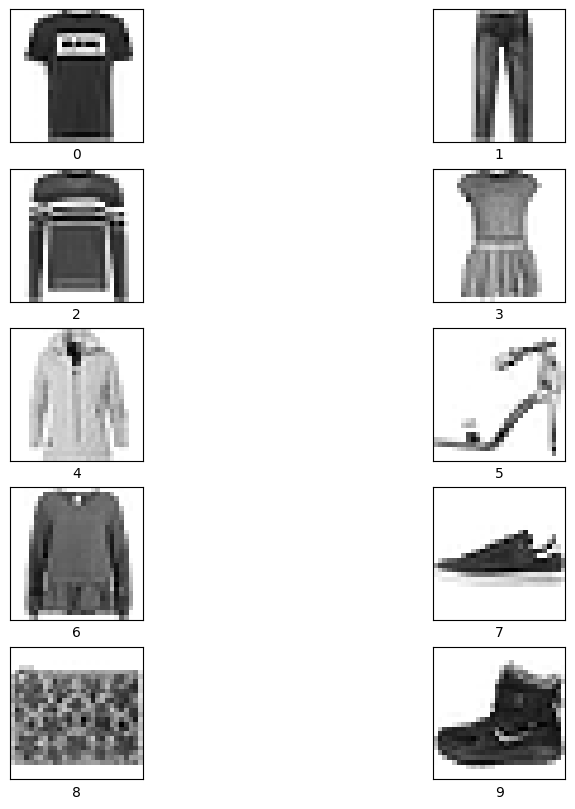

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    sample_image = train_images[train_labels == i][0]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_image, cmap=plt.cm.binary)
    plt.xlabel(i)
plt.show()

In [ ]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
1500/1500 [==============================] - 53s 33ms/step - loss: 0.6765 - accuracy: 0.8045 - val_loss: 0.3916 - val_accuracy: 0.8561
Epoch 2/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.3739 - accuracy: 0.8644 - val_loss: 0.3905 - val_accuracy: 0.8576
Epoch 3/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.3273 - accuracy: 0.8798 - val_loss: 0.3296 - val_accuracy: 0.8809
Epoch 4/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.2999 - accuracy: 0.8911 - val_loss: 0.3333 - val_accuracy: 0.8783
Epoch 5/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2798 - accuracy: 0.8969 - val_loss: 0.3100 - val_accuracy: 0.8881
Epoch 6/10
1500/1500 [==============================] - 48s 32ms/step - loss: 0.2632 - accuracy: 0.9033 - val_loss: 0.3255 - val_accuracy: 0.8858
Epoch 7/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.2458 - accuracy: 0.9092 - val_loss: 0.3021 -

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.3434 - accuracy: 0.8912

Test accuracy: 0.8912000060081482


In [ ]:
# Predictions on test dataset
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 3s 8ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test_labels, predicted_classes))
print(classification_report(test_labels, predicted_classes))

[[861   1  11  16   2   1 106   0   2   0]
 [  2 971   2  15   2   0   5   0   3   0]
 [ 20   0 798   8  70   0 103   0   1   0]
 [ 27   5   7 904  18   0  38   0   1   0]
 [  0   0  46  39 808   0 105   0   1   1]
 [  0   0   0   0   0 978   0  13   0   9]
 [125   0  61  24  46   0 732   0  12   0]
 [  0   0   0   0   0  29   0 928   1  42]
 [  8   2   6   1   4   3  10   2 963   1]
 [  1   0   0   0   0  11   0  19   0 969]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.86      0.80      0.83      1000
           3       0.90      0.90      0.90      1000
           4       0.85      0.81      0.83      1000
           5       0.96      0.98      0.97      1000
           6       0.67      0.73      0.70      1000
           7       0.96      0.93      0.95      1000
           8       0.98      0.96      0.97      1000
           9       0.95     

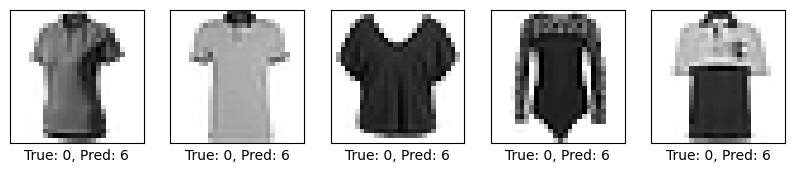

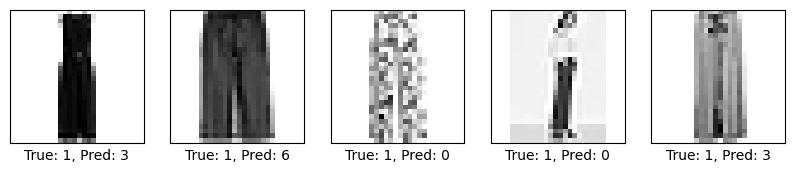

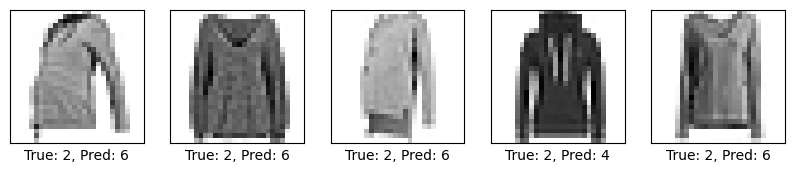

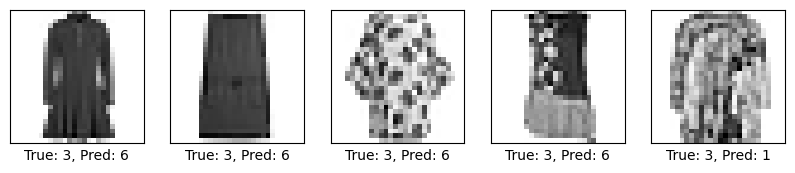

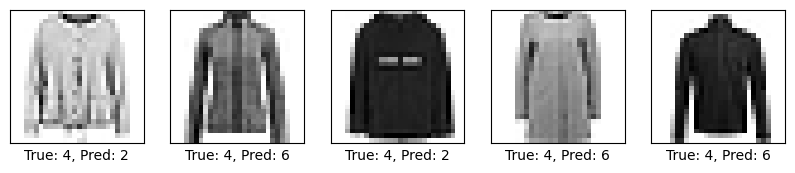

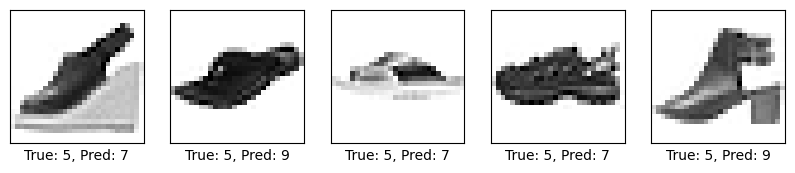

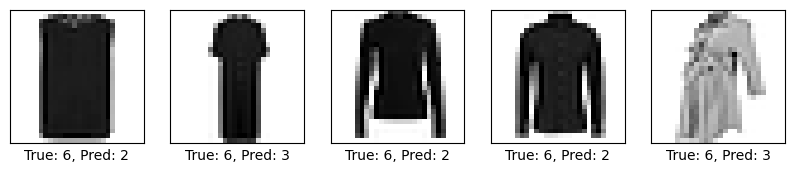

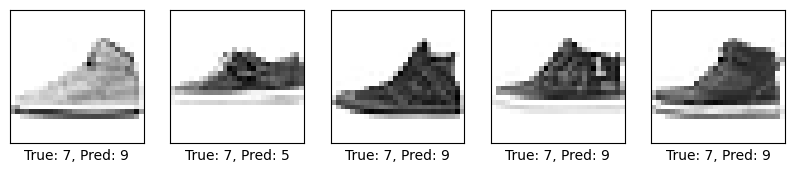

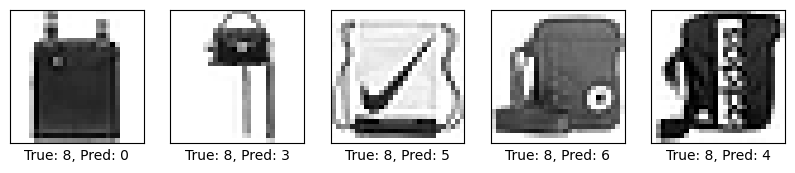

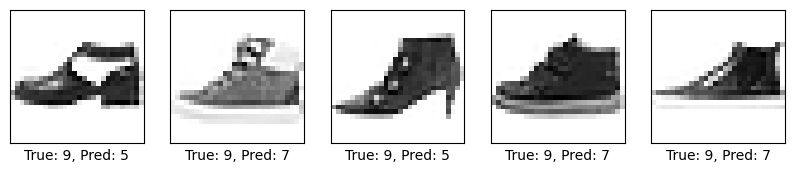

In [ ]:
# Analyze misclassified images for each class
misclassified = np.where(predicted_classes != test_labels)[0]
misclassified_samples = {label: [] for label in range(10)}
for index in misclassified:
    true_label = test_labels[index]
    if len(misclassified_samples[true_label]) < 5:
        misclassified_samples[true_label].append(index)

# Display 5 misclassified images for each class
for label, indices in misclassified_samples.items():
    plt.figure(figsize=(10, 2))
    for i, index in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[index], cmap=plt.cm.binary)
        plt.xlabel(f"True: {label}, Pred: {predicted_classes[index]}")
    plt.show()